# <center>An Introduction to</center>
# <center>Generative Adversarial Networks</center>
# <center>with PyTorch</center>

### David Mertz

  * Data Scientist
  * Chief Technology Officer, Bold Metrics Inc.
  * Trainer
  * Pythonista
  
### mertz@kdm.training

# Generative Adversarial Networks (GANs)

### GANs  have been used most widely in image generation contexts
### Can be applied equally to other domains

### When applied to images, GAN's often produce "surreal" and sometimes disturbing resemblances to real images.



### While a GAN is *technically* a kind of unsupervised learning, it cleverly captures much of the power of supervised learning models. 

(... what's the difference?)

### Supervised learning

* Start out with **tagged training data**
  * Classifiers predict target in several classes
  * Regressors predict target in continuous numeric range
* Require initial mechanism to identify canonical answers (e.g. human judgement)

### Unsupervised learning

* Data features, but no target per se
* No *a priori* to compare to prediction
* E.g. **clustering**, **decomposition**

### Generative Adversarial Network

* Only examples of the positive class
* Implicit negative class of "anything else"
* The "adversaries" are supervised models
* The adversaries provide each other's targets!

Artist and AI enthusiast Robbie Barrat made these [images derived from painted nudes](https://twitter.com/DrBeef_/status/978732422085988352/photo/1?ref_src=twsrc%5Etfw%7Ctwcamp%5Etweetembed%7Ctwterm%5E978732422085988352&ref_url=https%3A%2F%2Fwww.zmescience.com%2Fscience%2Fai-nudes-surreal-185131341%2F):

![GAN Nudes](img/GAN-nudes.png)

Martin Giles in [MIT Technology Review](https://www.technologyreview.com/s/610253/the-ganfather-the-man-whos-given-machines-the-gift-of-imagination/) shows authentic seeming generated images of "fake celebrities:"

![GAN celebs](img/GAN-celebs.png)

One neural network in a GAN is a "generator"

* Generate new data that cannot be distinguished from genuine samples
* We start with training datasets, but do not know what identifies correctness.  
* Correctness is defined by "belonging to the training set" 
* ...as opposed to being any other (distribution of) possible values for the features

The second neural network is a "discriminator." 
* Distinguish synthetic samples from genuine ones
* The discriminator uses supervised learning, since **we** know which images are fake

Real world versus GANs:

* Real world data is rarely activately trying to fool a network
* GAN: generator is specifically trying to outwit the discriminator

However...  

* In forgery or fraud, a malicious actor is trying to create currency, or artwork, or some other item that can pass inspection by (human or machine) discriminators
* In evolution, some organisms use camouflage to appear as something else

This O'Reilly Press illustration is a good overview of the structure of a GAN:

![GAN schema](img/gan_schema.png)

### Super-Resolution

A fascinating application of GANs is [super-resolution](https://arxiv.org/abs/1609.04802).

Essentially, we train the discriminator to recognize "high-resolution" and provide the generator with low-resolution, but real, images as its input vector.

![Super-resolution](img/super-resolution.png)

Image credit: [Christopher Thomas](https://towardsdatascience.com/deep-learning-based-super-resolution-without-using-a-gan-11c9bb5b6cd5)

### A toy example

The code shown is adapted from a GAN written by Dev Nag in his blog post [Generative Adversarial Networks (GANs) in 50 lines of code (PyTorch)](https://medium.com/@devnag/generative-adversarial-networks-gans-in-50-lines-of-code-pytorch-e81b79659e3f).  

For simplicity of presentation, all this GAN is trying to learn is a Gaussian random distribution.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import skew, kurtosis
import torch
import torch.nn as nn
import torch.optim as optim
from torch import sigmoid, tanh, relu

# For demonstration, we can use CPU target if CUDA not available
device = torch.device('cpu')

# Check the status of the GPU (if present)
if torch.cuda.is_available():
    torch.cuda.memory_allocated()
    # *MUCH* faster to run on GPU
    device = torch.device('cuda') 
    
print(device)

cpu


### Create the dataset

We can easily create samples from a Gaussian distribution.  The **features** we will us to characterize a sample are the first four moments of the sample; we could easily use the raw points, or other abstractions of the "shape" of the data, as we wish.

```python
def decorate_with_diffs(data, exponent, remove_raw_data=False):
    mean = torch.mean(data.data, 1, keepdim=True)
    mean_broadcast = torch.mul(torch.ones(data.size()), mean.tolist()[0][0])
    diffs = torch.pow(data - mean_broadcast, exponent)
    if remove_raw_data:
        return torch.cat([diffs], 1)
    else:
        return torch.cat([data, diffs], 1)
    
# Unused data features (experiment with these on your own).
# Raw data
preprocess, get_num_features = lambda data: data, lambda x: x
# Data and variances
preprocess, get_num_features = lambda data: decorate_with_diffs(data, 2.0), lambda x: x * 2
# Data and diffs
preprocess, get_num_features = lambda data: decorate_with_diffs(data, 1.0), lambda x: x * 2
```

In [2]:
def get_moments(d):
    # Return the first 4 moments of the data provided
    mean = torch.mean(d)
    diffs = d - mean
    var = torch.mean(torch.pow(diffs, 2.0))
    std = torch.pow(var, 0.5)
    zscores = diffs / std
    skews = torch.mean(torch.pow(zscores, 3.0))
    # excess kurtosis, should be 0 for Gaussian
    kurtoses = torch.mean(torch.pow(zscores, 4.0)) - 3.0  
    final = torch.cat((mean.reshape(1,), std.reshape(1,), 
                       skews.reshape(1,), kurtoses.reshape(1,)))
    return final

In [3]:
# Data points
def d_sampler(n=500, mu=4, sigma=1.25):
    "Provide `n` random Gaussian distributed points with mean `mu` and std `sigma`"
    return torch.Tensor(np.random.normal(mu, sigma, n)).to(device)

def gi_sampler(m=500, n=1):
    "Uniform-dist data into generator, NOT Gaussian"
    return torch.rand(m, n).to(device)

preprocess = get_moments

### Utility functions

In [4]:
def extract(v):
    return v.data.storage().tolist() 

def stats(v):
    d = extract(v)
    return (np.mean(d), np.std(d), skew(d), kurtosis(d))

### Visualize a sample from the target distribution

Reminder of what we are trying to imitate with the GAN.  

* Since these are samples, somewhat different each time we pull from distribution
* For a large sample (5000 here) the "shape" is obvious

Mean: 4.02 | Std: 1.26 | Skew: 0.06 | Kurt: 0.050123


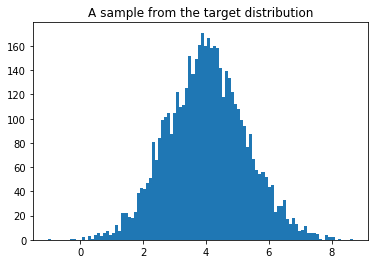

In [5]:
v = d_sampler(5000)
print("Mean: %.2f | Std: %.2f | Skew: %.2f | Kurt: %2f" % stats(v))
plt.hist(v.cpu(), bins=100)
plt.title("A sample from the target distribution");

#### Visualize a sample from the target distribution (continued)

* In GAN presented here, samples are 500 points from the same distribution
* Looks much more "stochastic" 

Mean: 4.01 | Std: 1.27 | Skew: 0.04 | Kurt: -0.216963


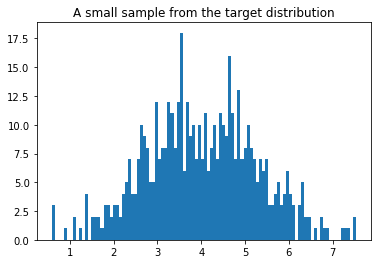

In [6]:
v = d_sampler()
print("Mean: %.2f | Std: %.2f | Skew: %.2f | Kurt: %2f" % stats(v))
plt.hist(v.cpu(), bins=100)
plt.title("A small sample from the target distribution");

### Visualize the noise input

* Large sample:

Mean: 0.50 | Std: 0.29 | Skew: 0.02 | Kurt: -1.169280


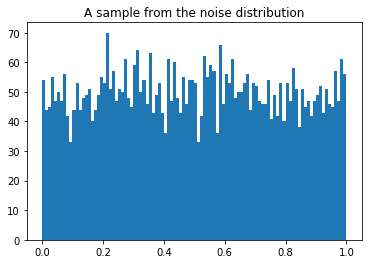

In [7]:
v = gi_sampler(5000).flatten()
print("Mean: %.2f | Std: %.2f | Skew: %.2f | Kurt: %2f" % stats(v))
plt.hist(v.cpu(), bins=100)
plt.title("A sample from the noise distribution");

### Visualize the noise input (continued)

* Small sample, per GAN used:

Mean: 0.49 | Std: 0.28 | Skew: 0.13 | Kurt: -1.116548


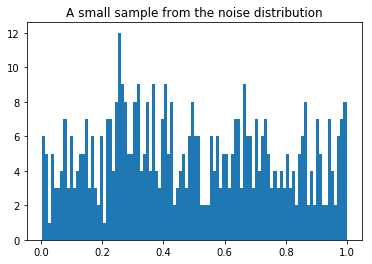

In [8]:
v = gi_sampler().flatten()
print("Mean: %.2f | Std: %.2f | Skew: %.2f | Kurt: %2f" % stats(v))
plt.hist(v.cpu(), bins=100)
plt.title("A small sample from the noise distribution");

### Define the Models

Define a generator and a discriminator in a standard fashion for PyTorch models.  Both have 3 linear layers.

In [9]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, f):
        super().__init__()
        self.dropout = nn.Dropout(0.25)
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.f = f

    def forward(self, x):
        x = self.map1(x)
        x = self.dropout(x)  # Can we avoid a local trap?
        x = self.f(x)
        x = self.map2(x)
        x = self.dropout(x)  # Can we avoid a local trap?
        x = self.f(x)
        x = self.map3(x)
        return x

In [10]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, f):
        super().__init__()
        self.dropout = nn.Dropout(0.25)
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.f = f

    def forward(self, x):
        x = self.map1(x)
        x = self.f(x)
        x = self.map2(x)
        x = self.f(x)
        x = self.map3(x)
        x = self.f(x)
        return x

### Instantiate models, loss, and optimizer

In [11]:
# Model parameters
minibatch_size = 4
num_epochs = 5001
print_interval = 500
d_steps = 20
g_steps = 20

G = Generator(input_size=1,   # Random noise dimension, per output vector
              hidden_size=10, # Generator complexity
              output_size=1,  # Single output for successful forgery or not
              f=relu          # Activation function
             ).to(device)

# Use input_size = get_num_features(...) if you try other examples
D = Discriminator(input_size=4,   # 4 moments/features
                  hidden_size=10, # Discriminator complexity
                  output_size=1,  # Single output for 'real' vs. 'fake' classification
                  f=sigmoid       # Activation function
                 ).to(device)

In [12]:
# Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
criterion = nn.BCELoss()  

# Stochastic Gradient Descent optimizers
d_learning_rate = 2e-4
g_learning_rate = 2e-4
sgd_momentum = 0.9
d_optimizer = optim.SGD(D.parameters(), lr=d_learning_rate, momentum=sgd_momentum)
g_optimizer = optim.SGD(G.parameters(), lr=g_learning_rate, momentum=sgd_momentum)

### Train the model

During training we will show some information and visualization of the progress.

```python
def train(minibatch_size=500, g_input_size=1, d_input_size=500):
    for epoch in range(num_epochs):
        for d_index in range(d_steps):
            # 1. Train D on real+fake
            D.zero_grad()

            #  1A: Train D on real
            d_real_data = d_sampler(d_input_size)
            d_real_decision = D(preprocess(d_real_data))
            d_real_error = criterion(d_real_decision, torch.ones([1]))  # ones = true
            d_real_error.backward() # compute/store gradients, but don't change params

            #  1B: Train D on fake
            d_gen_input = gi_sampler(minibatch_size, g_input_size)
            d_fake_data = G(d_gen_input).detach()  # avoid training G on these labels
            d_fake_decision = D(preprocess(d_fake_data.t()))
            d_fake_error = criterion(d_fake_decision, torch.zeros([1]))  # zeros = fake
            d_fake_error.backward()
            d_optimizer.step()     # Only optimizes D's parameters; 
                                   # changes based on stored gradients from backward()
```

### Train the model (continued #1)

```python
#
        for g_index in range(g_steps):
            # 2. Train G on D's response (but DO NOT train D on these labels)
            G.zero_grad()

            gen_input = gi_sampler(minibatch_size, g_input_size)
            g_fake_data = G(gen_input)
            dg_fake_decision = D(preprocess(g_fake_data.t()))
            # Train G to pretend it's genuine
            g_error = criterion(dg_fake_decision, torch.ones([1]).to(device))

            g_error.backward()
            g_optimizer.step()  # Only optimizes G's parameters
```

### Train the model (continued #2)

```python
#
        if epoch % print_interval == 0:
            rstats, fstats = stats(d_real_data), stats(d_fake_data)
            print("Epoch", epoch, "\n",
                  "Real Dist: Mean: %.2f, Std: %.2f, Skew: %.2f, Kurt: %2f\n" % rstats,
                  "Fake Dist: Mean: %.2f, Std: %.2f, Skew: %.2f, Kurt: %2f" % fstats)

            values = extract(g_fake_data)
            plt.hist(values, bins=100)
            plt.xlabel('Value')
            plt.ylabel('Count')
            plt.title('Histogram of Generated Distribution (epoch %d)' % epoch)
            plt.grid(True)
            plt.show()
```

In [13]:
def train(minibatch_size=500, g_input_size=1, d_input_size=500):
    for epoch in range(num_epochs):
        for d_index in range(d_steps):
            # 1. Train D on real+fake
            D.zero_grad()

            #  1A: Train D on real
            d_real_data = d_sampler(d_input_size)
            d_real_decision = D(preprocess(d_real_data))
            d_real_error = criterion(d_real_decision, torch.ones([1]).to(device))  # ones = true
            d_real_error.backward() # compute/store gradients, but don't change params

            #  1B: Train D on fake
            d_gen_input = gi_sampler(minibatch_size, g_input_size)
            d_fake_data = G(d_gen_input).detach()  # avoid training G on these labels
            d_fake_decision = D(preprocess(d_fake_data.t()))
            d_fake_error = criterion(d_fake_decision, torch.zeros([1]).to(device))  # zeros = fake
            d_fake_error.backward()
            d_optimizer.step()     # Only optimizes D's parameters; 
                                   # changes based on stored gradients from backward()

        for g_index in range(g_steps):
            # 2. Train G on D's response (but DO NOT train D on these labels)
            G.zero_grad()

            gen_input = gi_sampler(minibatch_size, g_input_size)
            g_fake_data = G(gen_input)
            dg_fake_decision = D(preprocess(g_fake_data.t()))
            # Train G to pretend it's genuine
            g_error = criterion(dg_fake_decision, torch.ones([1]).to(device))

            g_error.backward()
            g_optimizer.step()  # Only optimizes G's parameters

        if epoch % 1000 == 0:
            rstats, fstats = stats(d_real_data), stats(d_fake_data)
            print("Epoch", epoch, "\n",
                  "Real Dist: Mean: %.2f, Std: %.2f, Skew: %.2f, Kurt: %2f\n" % tuple(rstats),
                  "Fake Dist: Mean: %.2f, Std: %.2f, Skew: %.2f, Kurt: %2f" % tuple(fstats))

            values = extract(g_fake_data)
            if epoch % 5000 == 0:
                fig = plt.figure(figsize=(6,2.5))
                plt.hist(values, bins=100)
                plt.xlabel('Value')
                plt.ylabel('Count')
                plt.title('Histogram of Generated Distribution (epoch %d)' % epoch)
                plt.grid(False)
                plt.show()
            else:
                print()

Epoch 0 
 Real Dist: Mean: 4.01, Std: 1.29, Skew: 0.12, Kurt: -0.077075
 Fake Dist: Mean: 0.42, Std: 0.06, Skew: -0.33, Kurt: -0.364491


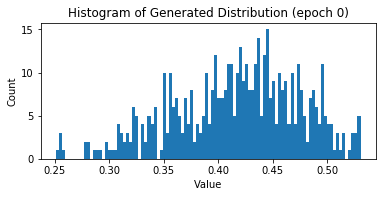

Epoch 1000 
 Real Dist: Mean: 3.92, Std: 1.29, Skew: -0.03, Kurt: -0.284384
 Fake Dist: Mean: 5.99, Std: 1.49, Skew: -0.08, Kurt: -0.246924

Epoch 2000 
 Real Dist: Mean: 4.02, Std: 1.32, Skew: -0.01, Kurt: -0.218719
 Fake Dist: Mean: 4.61, Std: 2.78, Skew: 0.75, Kurt: -0.201242

Epoch 3000 
 Real Dist: Mean: 3.94, Std: 1.29, Skew: -0.18, Kurt: 0.539401
 Fake Dist: Mean: 3.46, Std: 0.93, Skew: 0.28, Kurt: -0.450815

Epoch 4000 
 Real Dist: Mean: 3.93, Std: 1.23, Skew: 0.00, Kurt: 0.066148
 Fake Dist: Mean: 4.24, Std: 0.89, Skew: -0.05, Kurt: 0.380818

Epoch 5000 
 Real Dist: Mean: 4.04, Std: 1.24, Skew: 0.06, Kurt: -0.326888
 Fake Dist: Mean: 3.67, Std: 1.23, Skew: -0.22, Kurt: -0.475792


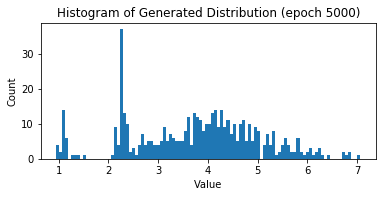

In [14]:
train()

### Training results

`In [14]: train()`

```
Epoch 0 
 Real Dist: Mean: 4.01, Std: 1.29, Skew: 0.12, Kurt: -0.077075
 Fake Dist: Mean: 0.42, Std: 0.06, Skew: -0.33, Kurt: -0.364491
```

![Epoch Zero](img/epoch-0.png)

```
Epoch 0 
 Real Dist: Mean: 4.01, Std: 1.29, Skew: 0.12, Kurt: -0.077075
 Fake Dist: Mean: 0.42, Std: 0.06, Skew: -0.33, Kurt: -0.364491

Epoch 1000 
 Real Dist: Mean: 3.92, Std: 1.29, Skew: -0.03, Kurt: -0.284384
 Fake Dist: Mean: 5.99, Std: 1.49, Skew: -0.08, Kurt: -0.246924

Epoch 2000 
 Real Dist: Mean: 4.02, Std: 1.32, Skew: -0.01, Kurt: -0.218719
 Fake Dist: Mean: 4.61, Std: 2.78, Skew: 0.75, Kurt: -0.201242

Epoch 3000 
 Real Dist: Mean: 3.94, Std: 1.29, Skew: -0.18, Kurt: 0.539401
 Fake Dist: Mean: 3.46, Std: 0.93, Skew: 0.28, Kurt: -0.450815

Epoch 4000 
 Real Dist: Mean: 3.93, Std: 1.23, Skew: 0.00, Kurt: 0.066148
 Fake Dist: Mean: 4.24, Std: 0.89, Skew: -0.05, Kurt: 0.380818
 
Epoch 5000 
 Real Dist: Mean: 4.04, Std: 1.24, Skew: 0.06, Kurt: -0.326888
 Fake Dist: Mean: 3.67, Std: 1.23, Skew: -0.22, Kurt: -0.475792

```

```
Epoch 5000 
 Real Dist: Mean: 4.04, Std: 1.24, Skew: 0.06, Kurt: -0.326888
 Fake Dist: Mean: 3.67, Std: 1.23, Skew: -0.22, Kurt: -0.475792
```

![Epoch 5000](img/epoch-5000.png)

## Pitfalls and guidelines

* When you train the discriminator, the generator will remain contant, and vice versa
* In a known domain, you might wish to pretrain the discriminator, or utilize a pre-trained model
* This gives the generator a more difficult adversary to work against

## Pitfalls and guidelines (continued #1)

* One adversary of the GAN can overpower the other
  * It depends on the network you configure
  * It depends on learning rates, optimizers, loss functions, etc.

* If the discriminator is too good, it will return values close to 0 or 1
  * The generator will be unable to find a meaningful gradient

* If the generator is too good, it will exploit weaknesses in the discriminator
  * Simpler patterns than "authenticity" might fool a discriminator
  * The surreal images demonstrate this

## Pitfalls and guidelines (continued #2)

* In the blog post that I base this GAN on is an illustration of multiple trained generators
* Randomized initial conditions make a big difference!
* Sometimes additional training rounds may force networks out of a poor local maximum
* Often an unbalance is reached where progress is not possible

![GAN generated distributions](img/GAN-generated-distributions.png)